# `Install Dependanices`

In [1]:
!pip install kaggle
!pip install opencv-python ultralytics
!pip install matplotlib numpy torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 19.5 MB/s eta 0:00:00


# `Install Data From Kaggle`

In [2]:
# Download Data From Kaggle Virual-Cloud
!kaggle datasets download omkarmanohardalvi/lungs-disease-dataset-4-types
# Unzip Data
!unzip lungs-disease-dataset-4-types.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

# `Loading Library`

In [3]:
# Main Library
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Create Model and prepare Dataset.
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Evaluation.
from sklearn.metrics import classification_report, precision_score, recall_score

### About the Dataset

The dataset used in this project consists of **chest X-ray images** prepared by combining multiple publicly available datasets. Special care was taken to ensure the dataset's integrity by removing duplicate images using a tool called **VisiPics**. The dataset is organized into the following classes:

- Normal Lungs Images showing healthy lung conditions.
- Diseased Lungs: Four categories representing various lung diseases:
  1. **Bacterial Pneumonia**
  2. **Corona Virus Disease**
  3. **Tuberculosis**
  4. **Viral Pneumonia**

To balance the dataset and improve the model's ability to generalize, **data augmentation** was applied with a factor of 6. This resulted in a final dataset containing approximately **10,000 images**. The augmented images include transformations like rotation, flipping, and contrast adjustments, enhancing diversity while retaining the original data's essence.

The dataset is split into three subsets:
- **Training Set**: Used to train the model.
- **Validation Set**: Used to evaluate the model during training and tune hyperparameters.
- **Test Set**: Used to assess the final model's performance on unseen data.

This dataset serves as a comprehensive collection for training deep learning models for lung disease classification.

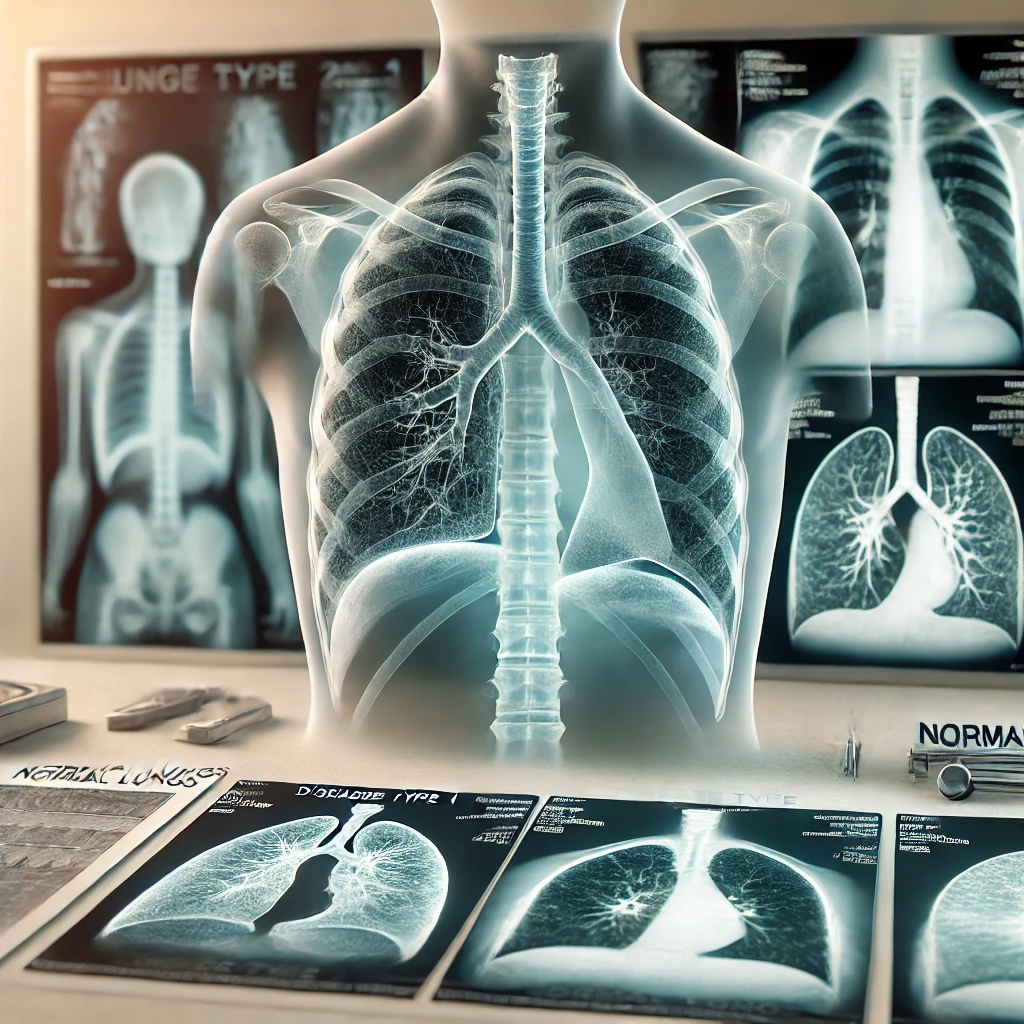

In [ ]:
from IPython.display import Image, display

# Display the image
image_path = '/content/x-ray.png'
display(Image(filename=image_path))

# `Loading Data & Create Augmentation`

In [4]:
data_dir = r'/content/Lung Disease Dataset'

augmentation_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
    ]
)


augmentation_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
    ]
)

data_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=augmentation_train)
data_val = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=augmentation_train)
data_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=augmentation_test)

class_label = data_train.classes

print(f'Class Label: {class_label}')
print(f'Number Of Class: {len(class_label)} Class')
print(f'Number Of Train Data: {len(data_train)}')
print(f'Number Of Test Data: {len(data_test)}')
print(f'Number Of Validation Data: {len(data_val)}')

Class Label: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Number Of Class: 5 Class
Number Of Train Data: 6054
Number Of Test Data: 2025
Number Of Validation Data: 2016


# `Transform Data Into DataLoader`


In [5]:
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)

## `Show Some Sample In Data.`

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels

tensor([4, 4, 4, 1, 2, 3, 3, 2, 0, 2, 2, 0, 4, 4, 2, 0, 2, 1, 3, 4, 2, 4, 0, 4,
        3, 4, 0, 3, 0, 0, 0, 0])

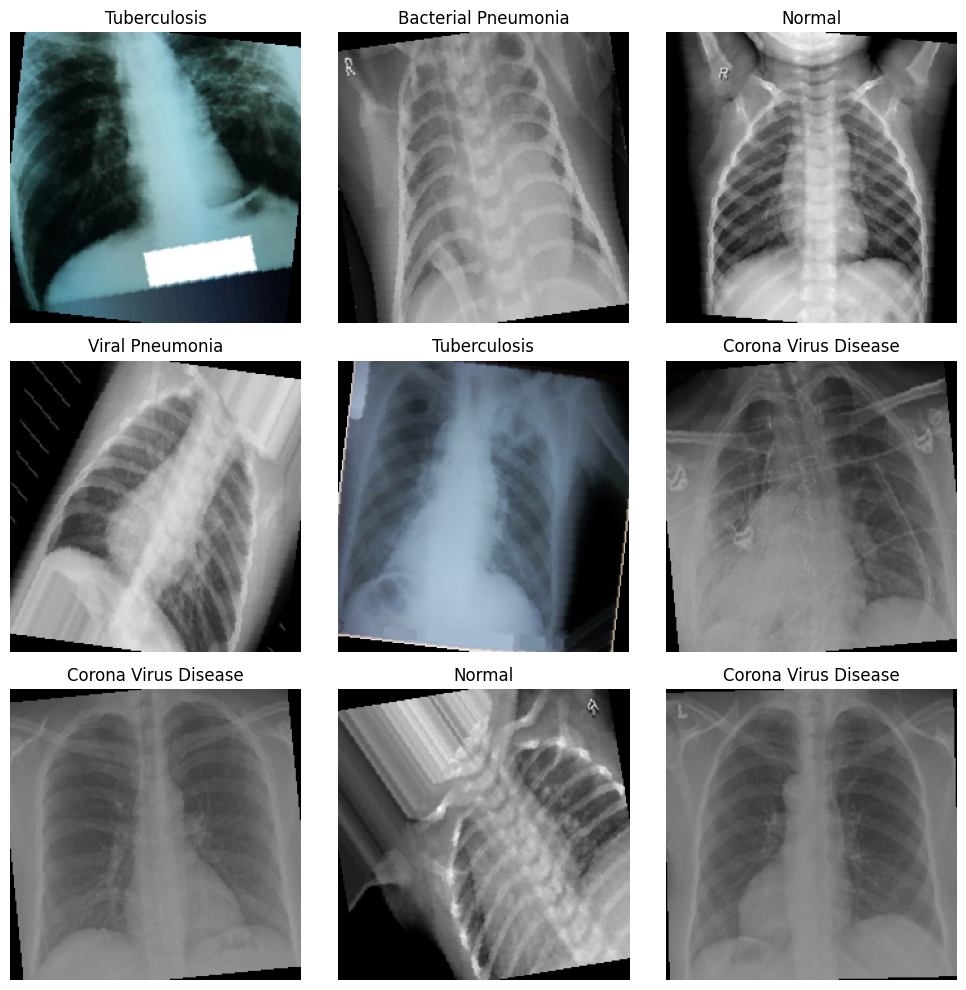

In [7]:
def imshow(img, title=None):
    """
    Display an image with optional title. The image is de-normalized using the
    specified mean and standard deviation values for visualization.

    Args:
        img (Tensor): The image to display, expected in PyTorch tensor format
                      with shape (C, H, W) where C is the number of channels.
        title (str, optional): The title to display above the image. Defaults to None.

    Returns:
        None
    """
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')


# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Define class names
class_names = data_train.classes  # Automatically derived from folder names

# Plot a few images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i].item()])
plt.tight_layout()
plt.show()

# `Make Some Analysis Visualization`

### `Visualizing Class Distribution`

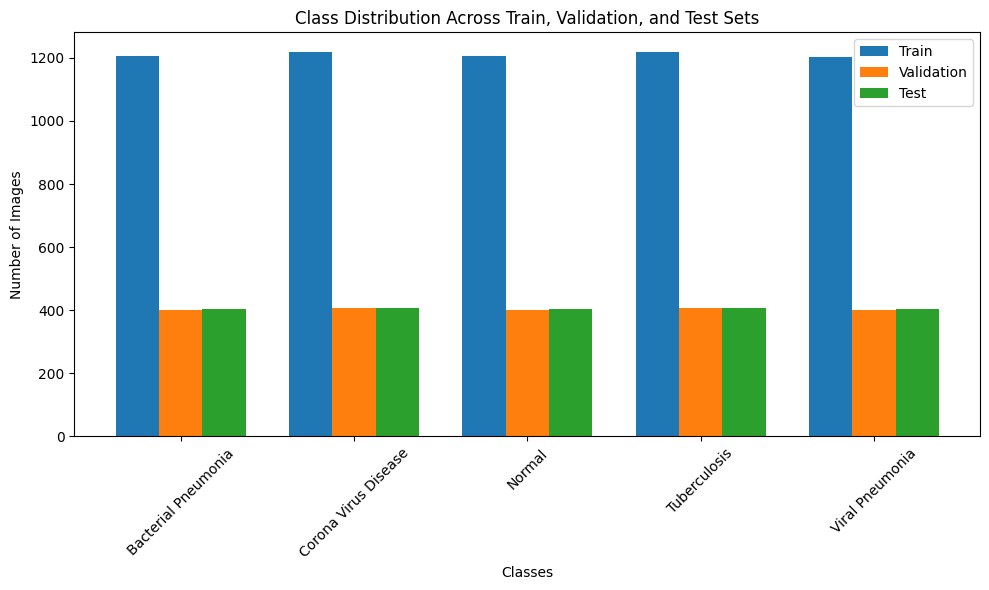

In [57]:
# Calculate the number of samples for each class in the training, val, test dataset
train_class_counts = [len([label for label in data_train.targets if label == i]) for i in range(len(class_label))]
val_class_counts = [len([label for label in data_val.targets if label == i]) for i in range(len(class_label))]
test_class_counts = [len([label for label in data_test.targets if label == i]) for i in range(len(class_label))]

# Set the x-axis range for plotting (one position for each class)
x = range(len(class_label))

# Create a figure for the bar plot
plt.figure(figsize=(10, 6))

# Plot the bar for the training, validation, testing dataset with a specific width and alignment
plt.bar(x, train_class_counts, width=0.25, label='Train', align='center')
plt.bar([i + 0.25 for i in x], val_class_counts, width=0.25, label='Validation', align='center')
plt.bar([i + 0.5 for i in x], test_class_counts, width=0.25, label='Test', align='center')


plt.xticks([i + 0.25 for i in x], class_label, rotation=45)  # Set the tick positions and labels on the x-axis

plt.xlabel('Classes')  # Label the x-axis as 'Classes'
plt.ylabel('Number of Images')  # Label the y-axis as 'Number of Images'

# Set the title of the plot
plt.title('Class Distribution Across Train, Validation, and Test Sets')

plt.legend()
plt.tight_layout()
plt.show()

### `Dataset Summary Table`

In [9]:
# Create a summary dictionary
summary = {
    "Dataset": ["Train", "Validation", "Test"],
    "Total Images": [len(data_train), len(data_val), len(data_test)],
}

# Add class counts
for i, cls in enumerate(class_label):
    summary[cls] = [
        len([label for label in data_train.targets if label == i]),
        len([label for label in data_val.targets if label == i]),
        len([label for label in data_test.targets if label == i]),
    ]

# Convert to DataFrame
df_summary = pd.DataFrame(summary)

df_summary

,Dataset,Total Images,Bacterial Pneumonia,Corona Virus Disease,Normal,Tuberculosis,Viral Pneumonia
0,Train,6054,1205,1218,1207,1220,1204
1,Validation,2016,401,406,402,406,401
2,Test,2025,403,407,404,408,403


### `analyze pixel intensity distribution`


In [53]:
def pixel_intensity_distribution_sample(dataloader, sample_batches=5):
    """
      Plots the pixel intensity distribution of a sampled subset of batches from a given dataloader.

      Args:
          dataloader (torch.utils.data.DataLoader): The dataloader containing the dataset to analyze.
              Each batch is expected to yield a tuple of (images, labels), where `images` is a tensor
              of shape (batch_size, channels, height, width) or (batch_size, height, width).
          sample_batches (int, optional): The number of batches to sample from the dataloader
              for computing the intensity distribution. Defaults to 5.

      Returns:
          None: The function displays a histogram of pixel intensities.

      Notes:
          - The function flattens the pixel values of images from the sampled batches and computes
            a histogram to visualize the pixel intensity distribution.
          - This function assumes the pixel values are in a numerical range suitable for a histogram
            (e.g., 0-255 for 8-bit images or 0-1 for normalized images).
          - The function uses Matplotlib to plot the histogram.

      Example:
          >>> from torch.utils.data import DataLoader
          >>> from torchvision.datasets import MNIST
          >>> from torchvision.transforms import ToTensor
          >>> import matplotlib.pyplot as plt
          >>>
          >>> # Create a DataLoader for the MNIST dataset
          >>> dataset = MNIST(root='data', train=True, transform=ToTensor(), download=True)
          >>> dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
          >>>
          >>> # Plot the pixel intensity distribution of the first 5 batches
          >>> pixel_intensity_distribution_sample(dataloader, sample_batches=5)
    """
    intensities = []

    # Iterate over a limited number of batches
    for i, (images, _) in enumerate(dataloader):
        if i >= sample_batches:
            break
        # Flatten the images and add their pixel values to the list
        for img in images:
            intensities.extend(img.cpu().numpy().flatten())

    # Plot the histogram of intensities
    plt.hist(intensities, bins=50, color='blue', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution (Sample Batches: {sample_batches})')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

In [54]:
len(next(iter(train_loader)))

2

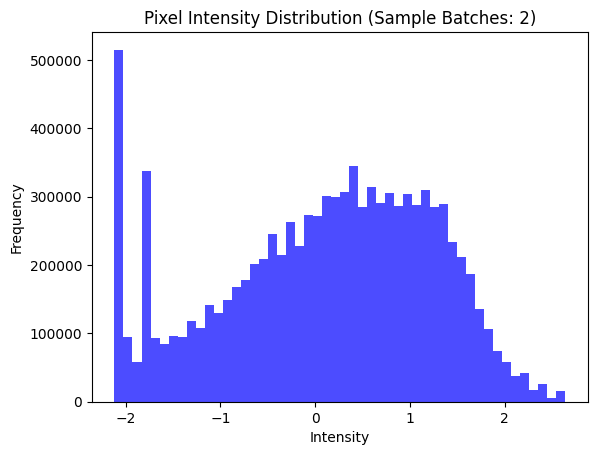

In [55]:
pixel_intensity_distribution_sample(train_loader, sample_batches=2)

### `Class Imbalance Analysis`

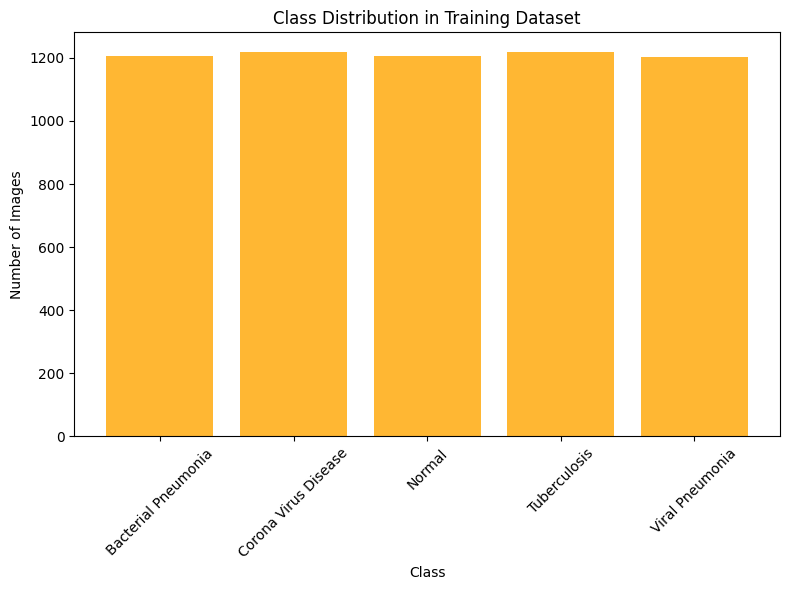

Proposed Weights for Weighted Loss: [1.0048132780082988, 0.994088669950739, 1.0031483015741507, 0.9924590163934426, 1.0056478405315614]


In [32]:
# Class distribution in the training dataset
train_class_counts = [len([label for label in data_train.targets if label == i]) for i in range(len(class_label))]

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
plt.bar(class_label, train_class_counts, color='orange', alpha=0.8)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Propose weighted loss calculation
total_images = len(data_train)
weights = [total_images / (len(class_label) * count) for count in train_class_counts]
print("Proposed Weights for Weighted Loss:", weights)

# `Building Pre-training Model`

In [ ]:
num_classes = len(class_label)
# Define loss function
criterion = nn.CrossEntropyLoss()

# Select Devise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device: {device}')

Device: cuda


## `1 - MobileNet Model`

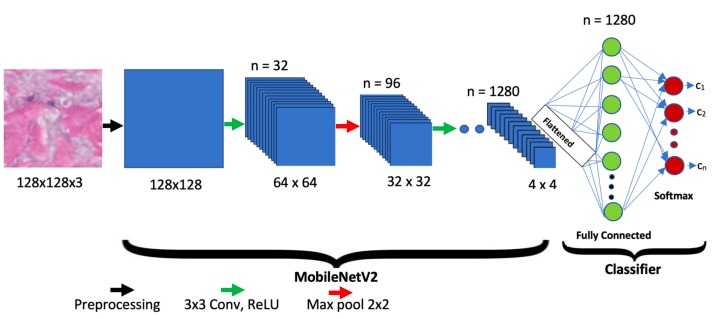

In [2]:
from IPython.display import Image, display

# Display the image
image_path = 'model_Arc/Mobile-Net.jpg'
display(Image(filename=image_path))

In [ ]:
# Load the MobileNet model (pre-trained on ImageNet)
mobilenet = models.mobilenet_v2(pretrained=True)

# Modify the final classification layer to match your number of classes (e.g., 5)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# Move model to GPU if available
mobilenet = mobilenet.to(device)

# Define loss function and optimizer
optimizer_mobilenet = torch.optim.Adam(mobilenet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]


## `2 - EfficientNet`

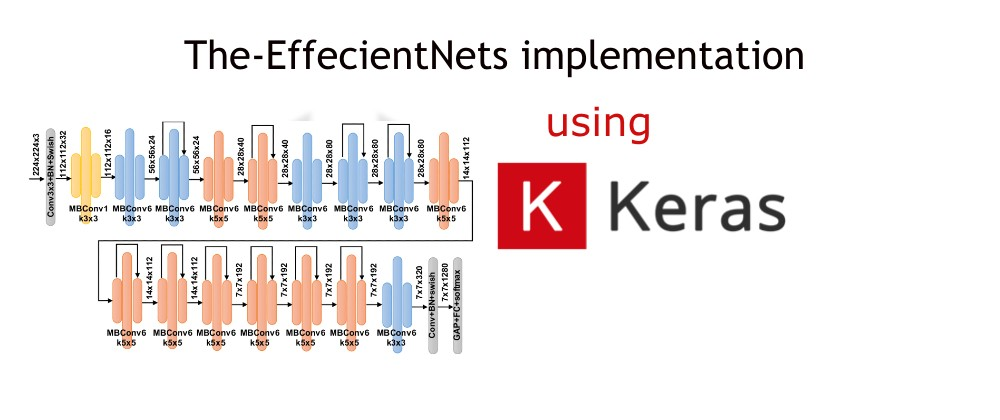

In [3]:
from IPython.display import Image, display

# Display the image
image_path = 'model_Arc/EfficientNetB0.jpg'
display(Image(filename=image_path))

In [ ]:
# Load EfficientNet
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

# Move models to GPU if available
efficientnet = efficientnet.to(device)

# Define loss function and optimizer
optimizer_efficientnet = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


## `3 - Resnet-50`

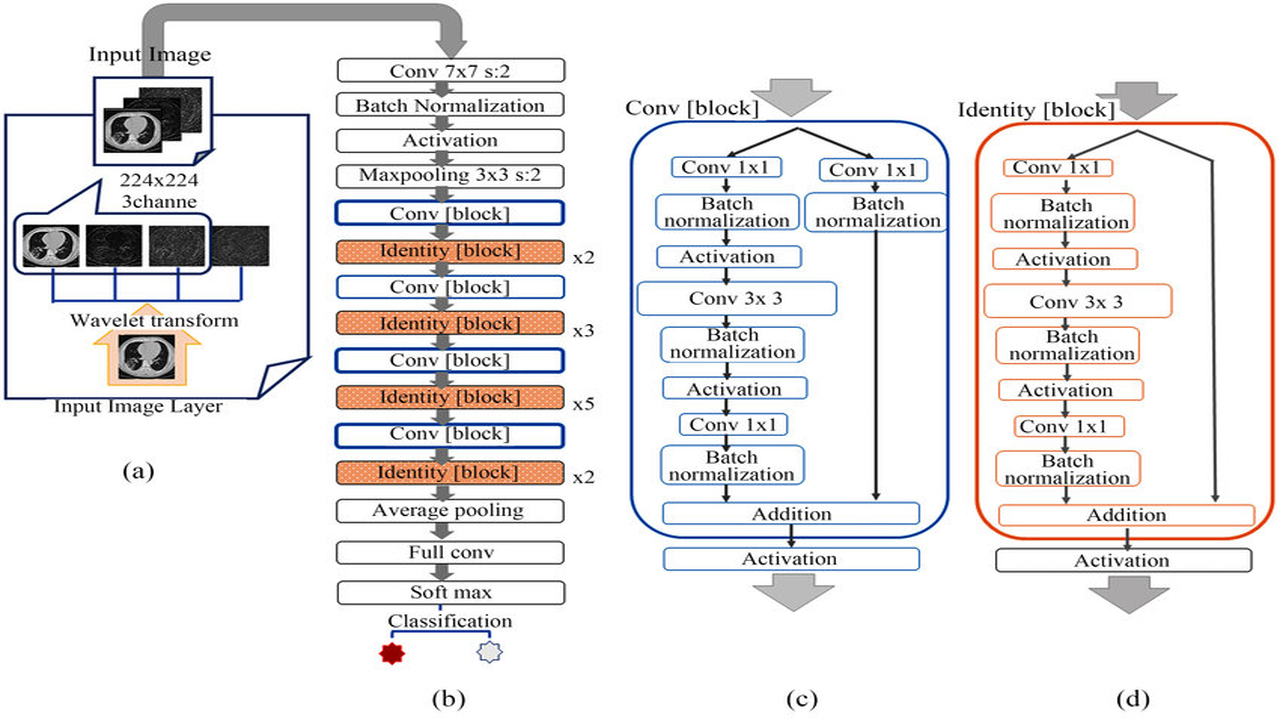

In [4]:
from IPython.display import Image, display

# Display the image
image_path = 'model_Arc/resnet_bannner.png'
display(Image(filename=image_path))

In [ ]:
# Load ResNet (e.g., ResNet-50)
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


# `Training Model In Data`

In [ ]:
# Training and Validation Loops (Shared Between Models)
def train_model(model, optimizer, train_loader, val_loader, epochs=10, model_name="Model"):
    """
    Train a deep learning model and evaluate it on a validation dataset after each epoch.

    Parameters:
        model (torch.nn.Module): The neural network model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        epochs (int, optional): The number of epochs to train the model. Default is 10.
        model_name (str, optional): A name for the model, used in log outputs. Default is "Model".

    Returns:
        None

    Side Effects:
        - Prints the training loss for each epoch.
        - Calls the `validate_model` function to print validation metrics, including loss, precision, recall, and classification report.

    Notes:
        - The model is updated using backpropagation on the training dataset.
        - The function assumes that a global `criterion` variable is defined for the loss function.
        - The model is moved to the same device (CPU or GPU) as the data.

    Example:
        >>> model = models.resnet50(pretrained=True)
        >>> model.fc = nn.Linear(model.fc.in_features, num_classes)
        >>> optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        >>> train_model(model, optimizer, train_loader, val_loader, epochs=5, model_name="ResNet-50")
    """
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"{model_name} Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

        # Validation (optional)
        validate_model(model, val_loader, model_name)
        print("-" * 50)
        print("-" * 50)

# `Testing Model In Data.`

In [ ]:
def validate_model(model, val_loader, model_name="Model"):
    """
    Evaluate a trained model on a validation dataset and compute performance metrics.

    Parameters:
        model (torch.nn.Module): The trained neural network model to be evaluated.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        model_name (str, optional): A name for the model, used in log outputs. Default is "Model".

    Returns:
        None

    Side Effects:
        - Prints the validation loss.
        - Prints the weighted precision, recall, and a detailed classification report for each class.

    Notes:
        - The function assumes that a global `criterion` variable is defined for the loss function.
        - The model is set to evaluation mode during validation to disable dropout and batch normalization updates.
        - Metrics (precision, recall, and classification report) are computed using `sklearn.metrics`.
        - The function assumes the validation dataset has class labels defined in `train_loader.dataset.classes`.

    Example:
        >>> validate_model(model, val_loader, model_name="EfficientNet")

    Output Example:
        EfficientNet Validation Loss: 0.1234
        EfficientNet Precision: 0.8901, Recall: 0.8802
        EfficientNet Classification Report:
                       precision    recall  f1-score   support
               class1       0.92      0.89      0.90       200
               class2       0.87      0.85      0.86       150
               class3       0.88      0.90      0.89       180
               class4       0.91      0.89      0.90       170
               class5       0.85      0.88      0.86       160

            accuracy                           0.88       860
         macro avg       0.89      0.88      0.88       860
      weighted avg       0.89      0.88      0.88       860
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Predictions
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate precision, recall, and classification report
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=train_loader.dataset.classes)

    print(f"{model_name} Validation Loss: {running_loss / len(val_loader):.4f}")
    print(f"{model_name} Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"{model_name} Classification Report:\n{report}")

# `Training & Evaluation Data In Mobilenet Model`

In [ ]:
# Train the model
train_model(model=mobilenet, optimizer=optimizer_mobilenet,
            train_loader=train_loader, val_loader=val_loader, epochs=10, model_name="Mobilenet")

Mobilenet Epoch 1/10, Loss: 0.5257
Mobilenet Validation Loss: 0.4097
Mobilenet Precision: 0.8348, Recall: 0.8358
Mobilenet Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.71      0.75      0.73       401
Corona Virus Disease       0.90      0.97      0.93       406
              Normal       0.90      0.89      0.90       402
        Tuberculosis       0.97      0.94      0.95       406
     Viral Pneumonia       0.69      0.63      0.66       401

            accuracy                           0.84      2016
           macro avg       0.83      0.84      0.83      2016
        weighted avg       0.83      0.84      0.83      2016

--------------------------------------------------
--------------------------------------------------
Mobilenet Epoch 2/10, Loss: 0.4134
Mobilenet Validation Loss: 0.4203
Mobilenet Precision: 0.8308, Recall: 0.8189
Mobilenet Classification Report:
                      precision    recall  f1

* `Testing Accuracy`


In [ ]:
validate_model(model=mobilenet, val_loader=test_loader, model_name="Mobilenet")

Mobilenet Validation Loss: 0.2789
Mobilenet Precision: 0.8862, Recall: 0.8869
Mobilenet Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.80      0.74      0.77       403
Corona Virus Disease       0.99      0.97      0.98       407
              Normal       0.93      0.97      0.95       404
        Tuberculosis       0.98      1.00      0.99       408
     Viral Pneumonia       0.73      0.75      0.74       403

            accuracy                           0.89      2025
           macro avg       0.89      0.89      0.89      2025
        weighted avg       0.89      0.89      0.89      2025



# `Training & Evaluation Data In Resnet-50 Model`

In [ ]:
# Train the model
train_model(resnet, optimizer_resnet, train_loader, val_loader, epochs=10, model_name="Resnet-50")

Resnet-50 Epoch 1/10, Loss: 0.6670
Resnet-50 Validation Loss: 0.7223
Resnet-50 Precision: 0.7364, Recall: 0.6820
Resnet-50 Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.73      0.19      0.31       401
Corona Virus Disease       0.91      0.78      0.84       406
              Normal       0.90      0.71      0.79       402
        Tuberculosis       0.69      0.96      0.80       406
     Viral Pneumonia       0.45      0.76      0.56       401

            accuracy                           0.68      2016
           macro avg       0.74      0.68      0.66      2016
        weighted avg       0.74      0.68      0.66      2016

--------------------------------------------------
--------------------------------------------------
Resnet-50 Epoch 2/10, Loss: 0.5057
Resnet-50 Validation Loss: 0.7271
Resnet-50 Precision: 0.7035, Recall: 0.7014
Resnet-50 Classification Report:
                      precision    recall  f1

* `Testing Accuracy`

In [ ]:
validate_model(model=resnet, val_loader=test_loader, model_name="Resnet-50")

Resnet-50 Validation Loss: 0.5044
Resnet-50 Precision: 0.8196, Recall: 0.8044
Resnet-50 Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.62      0.87      0.72       403
Corona Virus Disease       0.89      0.92      0.91       407
              Normal       0.83      0.98      0.90       404
        Tuberculosis       0.96      0.90      0.93       408
     Viral Pneumonia       0.80      0.34      0.48       403

            accuracy                           0.80      2025
           macro avg       0.82      0.80      0.79      2025
        weighted avg       0.82      0.80      0.79      2025



# `Training & Evaluation Data In Efficientnet Model`

In [ ]:
# Train the model
train_model(efficientnet, optimizer_efficientnet, train_loader, val_loader, epochs=10, model_name="EfficientNet")

EfficientNet Epoch 1/10, Loss: 0.4623
EfficientNet Validation Loss: 0.3421
EfficientNet Precision: 0.8626, Recall: 0.8586
EfficientNet Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.73      0.77      0.75       401
Corona Virus Disease       0.97      0.95      0.96       406
              Normal       0.96      0.88      0.92       402
        Tuberculosis       0.95      0.99      0.97       406
     Viral Pneumonia       0.69      0.70      0.70       401

            accuracy                           0.86      2016
           macro avg       0.86      0.86      0.86      2016
        weighted avg       0.86      0.86      0.86      2016

--------------------------------------------------
--------------------------------------------------
EfficientNet Epoch 2/10, Loss: 0.3274
EfficientNet Validation Loss: 0.3440
EfficientNet Precision: 0.8687, Recall: 0.8705
EfficientNet Classification Report:
                     

* `Testing Accuracy`

In [ ]:
validate_model(model=efficientnet, val_loader=test_loader, model_name="Efficientnet")

Efficientnet Validation Loss: 0.2926
Efficientnet Precision: 0.8956, Recall: 0.8919
Efficientnet Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.74      0.90      0.81       403
Corona Virus Disease       0.99      0.97      0.98       407
              Normal       0.94      0.97      0.95       404
        Tuberculosis       0.99      1.00      0.99       408
     Viral Pneumonia       0.83      0.63      0.72       403

            accuracy                           0.89      2025
           macro avg       0.90      0.89      0.89      2025
        weighted avg       0.90      0.89      0.89      2025



* `Save Model Weight`

In [ ]:
# Save the trained EfficientNet model
torch.save(efficientnet.state_dict(), '/content//efficientnet_model.pt')

- `Make Prediction For new image`

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

num_classes = 5
efficientnet = models.efficientnet_b0(pretrained=False)
efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, num_classes)
efficientnet.load_state_dict(torch.load('/content/efficientnet_model.pt'))

efficientnet.eval()

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the new image
image_path = '/content/Lung Disease Dataset/test/Bacterial Pneumonia/169.jpeg'
image = Image.open(image_path).convert('RGB')
image_tensor = image_transforms(image)
image_tensor = image_tensor.unsqueeze(0)

# Make a prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet.to(device)
image_tensor = image_tensor.to(device)
with torch.no_grad():
    output = efficientnet(image_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f"Predicted class: {class_label[predicted_class.item()]}")

Predicted class: Bacterial Pneumonia


<ipython-input-23-e001f3cee395>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet.load_state_dict(torch.load('/content/efficientnet_model.pt'))


# `Train Model In Yolov11`

* `1 - Training Yolo Without Augmentation`

In [ ]:
from ultralytics import YOLO
# Get Model
model_yolo = YOLO('yolo11s-cls.pt')

# Train Model
model_yolo.train(data="/content/Lung Disease Dataset", epochs=10, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 13.0M/13.0M [00:00<00:00, 93.6MB/s]


Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls.pt, data=/content/Lung Disease Dataset, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.0MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context

AMP: checks passed ✅


train: Scanning /content/Lung Disease Dataset/train... 6054 images, 0 corrupt: 100%|██████████| 6054/6054 [00:02<00:00, 2502.44it/s]

train: WARNING ⚠️ /content/Lung Disease Dataset/train/Corona Virus Disease/015.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Lung Disease Dataset/train/Corona Virus Disease/cavitating-pneumonia-4-day0-L.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Lung Disease Dataset/train/Corona Virus Disease/cavitating-pneumonia-4-day0-PA.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Lung Disease Dataset/train/Corona Virus Disease/covid-19-caso-70-1-L.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/Lung Disease Dataset/train/Corona Virus Disease/covid-19-pneumonia-7-L.jpg: corrupt JPEG restored and saved


train: New cache created: /content/Lung Disease Dataset/train.cache


val: Scanning /content/Lung Disease Dataset/val... 2016 images, 0 corrupt: 100%|██████████| 2016/2016 [00:03<00:00, 560.62it/s] 

val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(362).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(386).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(423).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(426).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/covid-19-pneumonia-38-l.jpg: corrupt JPEG restored and saved


val: New cache created: /content/Lung Disease Dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

       1/10      4.42G      1.672         16        640:   1%|          | 4/379 [00:04<04:56,  1.27it/s]
100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.864          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.878          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.858          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.901          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.893          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/379 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all      0.913          1



10 epochs completed in 1.019 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 11.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 11.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLO11s-cls summary (fused): 112 layers, 5,440,533 parameters, 0 gradients, 12.0 GFLOPs
train: /content/Lung Disease Dataset/train... found 6054 images in 5 classes ✅ 


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:916: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:918: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because 

val: /content/Lung Disease Dataset/val... found 2016 images in 5 classes ✅ 
test: /content/Lung Disease Dataset/test... found 2025 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


                   all      0.913          1
Speed: 0.6ms preprocess, 2.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6bced7cbb0>
curves: []
curves_results: []
fitness: 0.9565972089767456
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9131944179534912, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9565972089767456}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.5637038321722121, 'inference': 2.516179330765255, 'loss': 0.000549569016411191, 'postprocess': 0.0010699270263550774}
task: 'classify'
top1: 0.9131944179534912
top5: 1.0

In [ ]:
model_yolo.val(data="/content/Lung Disease Dataset")

Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s-cls summary (fused): 112 layers, 5,440,533 parameters, 0 gradients, 12.0 GFLOPs
train: /content/Lung Disease Dataset/train... found 6054 images in 5 classes ✅ 
val: /content/Lung Disease Dataset/val... found 2016 images in 5 classes ✅ 


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

test: /content/Lung Disease Dataset/test... found 2025 images in 5 classes ✅ 


val: Scanning /content/Lung Disease Dataset/val... 2016 images, 0 corrupt: 100%|██████████| 2016/2016 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(362).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(386).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(423).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/COVID19(426).jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/Lung Disease Dataset/val/Corona Virus Disease/covid-19-pneumonia-38-l.jpg: corrupt JPEG restored and saved



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:16<00:00,  1.64it/s]


                   all      0.913          1
Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6bcd15d1b0>
curves: []
curves_results: []
fitness: 0.9565972089767456
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9131944179534912, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9565972089767456}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.5971513806827484, 'inference': 4.562989586875553, 'loss': 0.0010880212935190352, 'postprocess': 0.002093140094999283}
task: 'classify'
top1: 0.9131944179534912
top5: 1.0